Este proyecto consiste en predecir la rentabilidad de los articulos del menu de un Retaurante. Este dataset fue extraido de Kaggle. La variable objetivo de este proyecto es la rentabilidad (Profitability)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('/Users/mariosanchez/Desktop/Restaurant_Menu/restaurant_menu_optimization_data.csv')

## Análisis exploratorio

In [5]:
df.head(3)

,RestaurantID,MenuCategory,MenuItem,Ingredients,Price,Profitability
0,R003,Beverages,Soda,['confidential'],2.55,Low
1,R001,Appetizers,Spinach Artichoke Dip,"['Tomatoes', 'Basil', 'Garlic', 'Olive Oil']",11.12,Medium
2,R003,Desserts,New York Cheesecake,"['Chocolate', 'Butter', 'Sugar', 'Eggs']",18.66,High


In [7]:
df.shape

(1000, 6)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   RestaurantID   1000 non-null   object 
 1   MenuCategory   1000 non-null   object 
 2   MenuItem       1000 non-null   object 
 3   Ingredients    1000 non-null   object 
 4   Price          1000 non-null   float64
 5   Profitability  1000 non-null   object 
dtypes: float64(1), object(5)
memory usage: 47.0+ KB


In [8]:
df.describe()

,Price
count,1000.00000
mean,12.81801
std,7.41713
min,2.01000
25%,4.86750
50%,12.53500
75%,17.69000
max,29.84000


In [9]:
df.nunique()

RestaurantID       3
MenuCategory       4
MenuItem          16
Ingredients        4
Price            767
Profitability      3
dtype: int64

In [10]:
df.isnull().sum()

RestaurantID     0
MenuCategory     0
MenuItem         0
Ingredients      0
Price            0
Profitability    0
dtype: int64

In [11]:
df.duplicated().sum()

27

## Preparación de los datos

### 1. Eliminar columnas no necesarias y datos duplicados

En primera instancia pensariamos que RestaurantID podría no entregar mucha información pero no es una variable atomizada, si no que se repetiten ciertos valores como veremos a continuación, por lo tanto la dejaremos por el momento

In [12]:
df.nunique()

RestaurantID       3
MenuCategory       4
MenuItem          16
Ingredients        4
Price            767
Profitability      3
dtype: int64

Las demás columnas no se encuentran con valores muy atomizados, ni columnas que entreguen solo 1 valor, por lo tanto dejaremos todas las columnas en primera instancia.

Ahora como vimos anteriormente, existen datos duplicados por lo cual los eliminaremos.

In [13]:
df.duplicated().sum()

27

In [15]:
df = df.drop_duplicates()
df.shape


(973, 6)

### 2. Tratamiento de valores núlos

Como vimos anteriormente no existen valores nulos por lo cual seguiremos al siguiente paso.

In [16]:
df.isnull().sum()

RestaurantID     0
MenuCategory     0
MenuItem         0
Ingredients      0
Price            0
Profitability    0
dtype: int64

### 3. Tratamiento de Outliers

La unica variable numerica es Precio, por lo cual graficaremos solo esta variable.

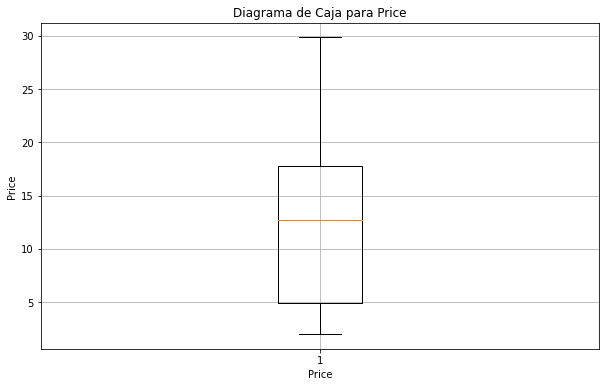

In [17]:
plt.figure(figsize=(10, 6))
plt.boxplot(df["Price"])
plt.title('Diagrama de Caja para Price')
plt.ylabel('Price')
plt.xlabel('Price')
plt.grid(True)
plt.show()

Vemos que no nos encontramos con valores outliers para esta columna.

Ahora las demas columnas como son categoricas veremos cuantas veces se repite cada variable dentro de la columna, para ver si es necesario eliminar algunas que no aporten mayor información al análisis.

In [18]:
df["RestaurantID"].value_counts()

R001    343
R002    315
R003    315
Name: RestaurantID, dtype: int64

In [19]:
df["MenuCategory"].value_counts()

Desserts       253
Beverages      248
Appetizers     248
Main Course    224
Name: MenuCategory, dtype: int64

In [20]:
df["MenuItem"].value_counts()

New York Cheesecake      70
Tiramisu                 69
Vegetable Stir-Fry       66
Soda                     66
Caprese Salad            65
Iced Tea                 64
Coffee                   63
Bruschetta               62
Spinach Artichoke Dip    62
Fruit Tart               60
Stuffed Mushrooms        59
Grilled Steak            55
Lemonade                 55
Shrimp Scampi            54
Chocolate Lava Cake      54
Chicken Alfredo          49
Name: MenuItem, dtype: int64

In [22]:
df["Ingredients"].value_counts()

['Chocolate', 'Butter', 'Sugar', 'Eggs']                  253
['confidential']                                          248
['Tomatoes', 'Basil', 'Garlic', 'Olive Oil']              248
['Chicken', 'Fettuccine', 'Alfredo Sauce', 'Parmesan']    224
Name: Ingredients, dtype: int64

In [21]:
df["Profitability"].value_counts()

Medium    478
High      383
Low       112
Name: Profitability, dtype: int64

### 4. Convertir variables categóricas a Dummies 

### 5. Normalizar variables numéricas

## Selección de variables

## Desarrollo y evaluación de modelos

## Reflexión